Trying to use an SVR for localizations instead of chi squared


In [1]:
from numpy import rad2deg,deg2rad,pi,sqrt,add,array,average
from healpy import ang2vec, newvisufunc
import numpy as np
from healpy import nside2npix,pix2ang
import burstutils as bf
#np.set_printoptions(threshold='nan')
np.set_printoptions(threshold=np.inf)


In [2]:
def relative_scale(detarray):
    """Takes the absolute # of counts in each detector, and converts to a relative scale. 
    """
    
    newverz = []
    
    for val in detarray:
        if min(detarray) == max(detarray):
            z = 0
        else: 
            z = (val - min(detarray))/(max(detarray)-min(detarray))

        newverz.append(z)
    return newverz

In [3]:
#Needs to know how to point to healpy 
from healpy import nside2npix,pix2ang
class Sky():
    """
    Generates an array of GRB's given 
    certains strength at different sky positions.
    
    Output should be an array. 
    """
    def __init__(self,NSIDE,strength):

        #depending on NSIDE, there will be anywhere from 12 to infinite spots on the sky w/ GRBs
        self.Ao = strength
        self.pixels = nside2npix(NSIDE)

        #want to convert these pixels into theta phi coords. 
        self.sourceangs = []
        for i in range(self.pixels):
            self.sourceangs.append(pix2ang(NSIDE,i))


In [4]:
GRBs = Sky(NSIDE=32,strength=500)

In [5]:
print(len(rad2deg(GRBs.sourceangs)))

12288


In [6]:


#sometimes one way works, sometimes another one does. Here's a workaround. 
try:
    from NoahSim import burstutils as bf
except:
    import burstutils as bf

from random import gauss
import statistics as s
import matplotlib.pyplot as plt

#making classes of objects, allows for different instances of burstcube, easy to compare. 
class FastCube():

    def __init__(self,background,dettilt,alternating=False):
        if alternating == False:
            self.tilt = deg2rad(dettilt)
            self.tiltA = self.tiltB = self.tiltC = self.tiltD = self.tilt
        
        else:
            self.tiltB = (float(input("Please enter the second tilt (deg) ")))
            self.tiltB = deg2rad(self.tiltB)
            self.tiltC = self.tiltA = deg2rad(dettilt)
            self.tiltD = self.tiltB
        
        self.zenith = [0 , 0]
        self.bg = background


        
    @property
    def detA(self):
        """BurstCube is composed of 4 separate scintillators to detect and localize events. 
        In this software package, they are labelled A through D. 
        """
        return [ self.zenith[0] + self.tiltA , self.zenith[1] ]
    @property 
    def detB(self):
        """BurstCube is composed of 4 separate scintillators to detect and localize events. 
        In this software package, they are labelled A through D. 
        """
        return [ self.zenith[0] + self.tiltB , self.zenith[1] + pi/2 ]
    @property
    def detC(self):
        """BurstCube is composed of 4 separate scintillators to detect and localize events. 
        In this software package, they are labelled A through D. 
        """
        return [ self.zenith[0] + self.tiltC , self.zenith[1] + pi ]
    @property 
    def detD(self):
        """BurstCube is composed of 4 separate scintillators to detect and localize events. 
        In this software package, they are labelled A through D. 
        """
        return [ self.zenith[0] + self.tiltD , self.zenith[1] + 3*pi/2 ]
    @property
    def normA(self):
        return  ang2vec(self.detA[0],self.detA[1])
    @property 
    def normB(self):
        return  ang2vec(self.detB[0],self.detB[1])
    @property
    def normC(self):
        return  ang2vec(self.detC[0],self.detC[1])
    @property 
    def normD(self):
        return  ang2vec(self.detD[0],self.detD[1])

    
    @property
    def dets(self):
        return [self.normA,self.normB,self.normC,self.normD] 

    #now that the properties of burstucbe have been designed, now its time to test the model's localization capabilities    

    def response2GRB(self, GRB,test=True,talk=False):   #is this how I inherit? 

    #first need to include the GRB.
       
        """
        Using x, respond2GRB will determine the sky position of an array of GRB sources assuming some inherent background noise within 
        detectors, along with fluctuations of either Gaussian or Poissonian nature. 

        Parameters
        ----------
        GRB : object
            An instance of the separately defined "GRBs" class that contains a number of evenly spaced sky positions of a given strength. 
        
        test : boolean 
            For sanity purposes, if the simulation seems to give unrealistic results, switching to test mode allows for much quicker sampling, allowing it easier to spot potential errors. 
        
        
        talk : boolean
            If desired, prints position by position results. 
        
        Returns
        ----------
        localizationerrors : array
            numpy array that contains the average localization uncertainty at each sky position. 
        
        Additionally, response2GRB will print the sky position it is currently sampling, along with the average offset of localizations at that spot. 
        
        """
        
        if test:
            sample = 1
            bottheta = 0
            toptheta = 180
            botphi = 0 
            topphi = 360
            botA = 10
            topA = 1000
            ntheta = 20   #over sky chi points
            nphi = 37
            nA = 100

        else:
            sample = len(GRB.sourceangs)   #number of GRBs you're testing
            bottheta = 0   #zenith
            toptheta = 120  #(elevation) range of theta values   horizon
            ntheta = 31   #over sky chi points  #binning

            botphi = 0 #azimuthal angles
            topphi = 360
            botA = 200  #range of amplitudes/strength of source it tries to match
            topA = 1000   #counts above background 
            nphi = 120
            nA = 12 
        self.localizationerrors = []   
        X = []
        for i in range(len(GRB.sourceangs)):
            
            sourceAng = GRB.sourceangs[i]
            if talk:
                print("Testing " + str(rad2deg(sourceAng)))
           #this check passes.       

            
           # print("Testing at " + str(np.rad2deg(GRB.sourceangs)))
            sourcexyz = ang2vec(sourceAng[0],sourceAng[1]) #cartesian position of the burst
                    #here's where I define how many times that is
                
            sepA=bf.angle(sourcexyz,self.normA)
            xA = bf.look_up_A(self.normA,sourcexyz)
                   # print("separation from A is " + str(np.rad2deg(sepA)))
                   #this check passes.  
               
            dtheoryA=GRB.Ao*bf.response(sepA,xA)  #still need to define strength, brb and gonna do that 
            if type(dtheoryA) == np.float64:
                dtheoryA = np.array([dtheoryA])
                   # print("dtheory test: " + str(dtheory))
                    # this check passes too. 
                    

            sepB=bf.angle(sourcexyz,self.normB)
            xB = bf.look_up_B(self.normB,sourcexyz)

                   # print("separation from B is " + str(np.rad2deg(sepB)))
                   #this check passes.  
               
            dtheoryB=GRB.Ao*bf.response(sepB,xB)  
                    #still need to define strength, brb and gonna do that 
            if type(dtheoryB) == np.float64:
                dtheoryB = np.array([dtheoryB])

                     
                   # print("dtheory test: " + str(dtheory))
                    # this check passes too. 

                


            sepC=bf.angle(sourcexyz,self.normC)
                   # print("separation from C is " + str(np.rad2deg(sepC)))
                   #this check passes.  
            xC =  bf.look_up_C(self.normC,sourcexyz)
            dtheoryC=GRB.Ao*bf.response(sepC,xC)  #still need to define strength, brb and gonna do that 
            if type(dtheoryC) == np.float64:
                dtheoryC = np.array([dtheoryC])
                   # print("dtheory test: " + str(dtheory))
                    # this check passes too
                
                

                
            sepD=bf.angle(sourcexyz,self.normD)
                   # print("separation from D is " + str(np.rad2deg(sepD)))
                   #this check passes.  
            xD = bf.look_up_D(self.normD,sourcexyz)
            dtheoryD=GRB.Ao*bf.response(sepD,xD)  #still need to define strength, brb and gonna do that 
            if type(dtheoryD) == np.float64:
                dtheoryD = np.array([dtheoryD])
                     
                   # print("dtheory test: " + str(dtheory))
            X1 = np.concatenate((dtheoryA,dtheoryB))
            X2 = np.concatenate((dtheoryC,dtheoryD))
            X3 = np.concatenate((X1,X2))
            X3 = relative_scale(X3)
            X.append(X3)   
        return np.array(X)
    

In [7]:
cubesat = FastCube(1000,45)

In [8]:
%matplotlib inline


In [15]:
def get_offset(Xs,ys,i,model):
    """Input the inded number, will tell you what the source is actually at, 
    the reconstructed position, and the offset. 
    This isn't even including the gaussian variations 
    yet so that will be even more noise so this should be really good. 
    
    """
    test  = Xs[i]
    test = test.reshape(1,-1)
    guess = model.predict(test)

   # print("Source location:"," ",ys[i])
    
    #print("Random forest guess:",guess)
    guesstheta,guessphi = deg2rad(guess[0][0]),deg2rad(guess[0][1])
    vectest = ang2vec(guesstheta,guessphi)
    
    sourcetheta,sourcephi = deg2rad(ys[i][0]),deg2rad(ys[i][1])
    vecsource = ang2vec(sourcetheta,sourcephi)
    #print(vectest)
    #print(vecsource)
    sep =  rad2deg(bf.angle(vecsource,vectest))
    
    #print("separation: ",sep, " degrees")
    return sep

In [16]:
def regression(N):
    Xs = cubesat.response2GRB(GRBs)

    ys = rad2deg(GRBs.sourceangs)
    Xs = Xs[0:N]
    ys = ys[0:N]
    
    from sklearn.datasets import make_regression
    from sklearn.multioutput import MultiOutputRegressor
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn import preprocessing, cross_validation
    from sklearn.neural_network import MLPRegressor
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.svm import SVR
    from sklearn import linear_model

    X_train,X_test,y_train,y_test = cross_validation.train_test_split(Xs,ys,test_size=0.27)
    #clf = linear_model.LinearRegression()
    clf = RandomForestRegressor()
    clf.n_estimators = 1000
    #clf = SVR()
    #clf = MLPRegressor()
    model = MultiOutputRegressor(estimator=clf)
    model.fit(X_train,y_train)
    print("R**2 = ", model.score(X_test,y_test))
    
    seps = []
    for i in range(N):
        sep = get_offset(Xs,ys,i,model)
        seps.append(sep)
    
    import matplotlib.pyplot as plt

    plt.plot(seps,'.')
    plt.xlabel("Pixel # (Descending from zenith @ [0,0])")
    plt.ylabel('Loc Offset')
    plt.title("How good this ML Model (Random Forest) is at assigning the relative counts to the given sky position")
    return seps
    

R**2 =  0.6725851967606464


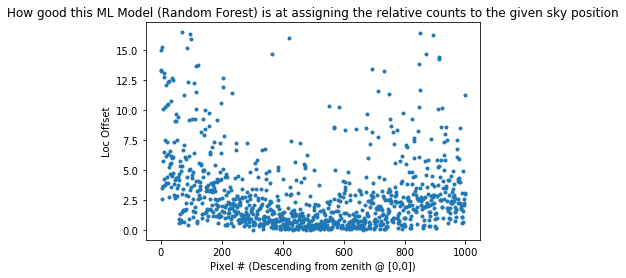

In [17]:
seps = regression(1000)

In [18]:
import statistics as s

In [19]:
s.mean(seps)

2.9344414269225148

In [20]:
s.stdev(seps)

3.11762257982777

In [21]:
s.median(seps)

1.973638857908334

In [ ]:
np.savetxt('y.txt',ys)

In [ ]:
ys = rad2deg(GRBs.sourceangs)

In [ ]:
Xs = Xs[0:1000]
ys = ys[0:1000]  #only a good sample size

Example SVR
-----------

from sklearn import svm
 X = [[0, 0], [2, 2]]
 
 y = [0.5, 2.5]
 
 clf = svm.SVR()

clf.fit(X, y) 

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
 clf.predict([[1, 1]])
array([ 1.5])

In [ ]:
from sklearn.datasets import make_regression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import preprocessing, cross_validation

X_train,X_test,y_train,y_test = cross_validation.train_test_split(Xs,ys,test_size=0.27)

#model = MultiOutputRegressor(GradientBoostingRegressor(random_state=0))
#model.fit(X_train, y_train)
#.predict(X)

In [ ]:
model = MultiOutputRegressor(estimator=clf)

In [ ]:
model.fit(X_train,y_train)

In [ ]:
model.score(X_test,y_test)

In [ ]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
#clf.fit([[getattr(t, 'x%d' % i) for i in range(1, 8)] for t in texts],
#        [t.y for t in texts])

In [ ]:
X_train,X_test,y_train,y_test = cross_validation.train_test_split(Xs,ys,test_size=0.27)


In [ ]:
#END NEW VERZ

In [ ]:
np.shape(X)

In [ ]:
from sklearn import svm
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
# Look at parameters used by our current forest
print('Parameters currently in use:\n')


In [ ]:
rf = RandomForestRegressor()
model = svm.SVR()

In [ ]:
clf = MultiOutputRegressor(estimator=rf)

In [ ]:
from sklearn import preprocessing, cross_validation

X_train,X_test,y_train,y_test = cross_validation.train_test_split(Xs,ys,test_size=0.27)


In [ ]:
X_test[21]

In [ ]:
clf.fit(X_train,y_train)

In [ ]:
clf.score(X_test,y_test)

In [ ]:
test  = Xs[6]
test = test.reshape(1,-1)


In [ ]:
clf.predict(test)

In [ ]:
ys[6]

In [ ]:
def get_offset(i):
    """Input the inded number, will tell you what the source is actually at, 
    the reconstructed position, and the offset. 
    This isn't even including the gaussian variations 
    yet so that will be even more noise so this should be really good. 
    
    """
    test  = Xs[6]
    test = test.reshape(1,-1)
    guess = model.predict(test)

   # print("Source location:"," ",ys[i])
    
    #print("Random forest guess:",guess)
    guesstheta,guessphi = deg2rad(guess[0][0]),deg2rad(guess[0][1])
    vectest = ang2vec(guesstheta,guessphi)
    
    sourcetheta,sourcephi = deg2rad(ys[i][0]),deg2rad(ys[i][1])
    vecsource = ang2vec(sourcetheta,sourcephi)
    #print(vectest)
    #print(vecsource)
    sep =  rad2deg(bf.angle(vecsource,vectest))
    
    #print("separation: ",sep, " degrees")
    return sep

In [ ]:
seps = []

for i in range(1000):
    sep = get_offset(i)
    seps.append(sep)

In [ ]:
ys[4000]

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(seps)
plt.xlabel("Step #")
plt.ylabel('Loc Offset')

In [ ]:
            
                #coarse to fine optimization
                chiA = bf.quad_solver(detcountsA,self.normA,bottheta,toptheta,botphi,topphi,botA,topA,ntheta,nphi,nA,self.bg,A=True)
                chiB = bf.quad_solver(detcountsB,self.normB,bottheta,toptheta,botphi,topphi,botA,topA,ntheta,nphi,nA,self.bg,B=True)
                chiC = bf.quad_solver(detcountsC,self.normC,bottheta,toptheta,botphi,topphi,botA,topA,ntheta,nphi,nA,self.bg,C=True)
                chiD = bf.quad_solver(detcountsD,self.normD,bottheta,toptheta,botphi,topphi,botA,topA,ntheta,nphi,nA,self.bg,D=True)
                
                chisquared = add(add(chiA,chiB),add(chiC,chiD)) #adds it all up for total chi2
                
                #print("Chi squareds: " +str(chisquared))
                
                
                thetaloc, philoc, Aguess = bf.indexer(chisquared,bottheta,toptheta,botphi,topphi,botA,topA,ntheta,nphi,nA)
                recvec = ang2vec(deg2rad(thetaloc),deg2rad(philoc))
                locoffset = rad2deg(bf.angle(sourcexyz,recvec))
               # print("Loc offset = " + str(locoffset) + " deg")
                
                locunc.append(locoffset)
                loop +=1
            if talk:
                print("Avg loc offset = " + str(average(locunc)) + " deg.")

            self.localizationerrors.append(s.mean(locunc))
        return self.localizationerrors